In [1]:
import numpy as np
import glob

import rioxarray as rio
import xarray as xr

from natsort import natsorted 
import matplotlib.pyplot as plt

# import pandas as pd

In [2]:
# mask created from the gaez pxv daily deviation files, ngrids with data = 2,287,408
f_mask_daydev='/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/mask_2287408_5m.nc'

# mask created from the monthly rst files, ngrids with data (no antarctica) = 2,268,708
f_mask_monthly= '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/mask_2268708_5m.nc'

# the rst ALOS mask, ngrids gt value 0 = 2,295,358
f_mask_ALOS= '/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/ALOSmask5m_fill.rst'

### get mask created from the gaez pxv daily deviation files, ngrids eq value 1 is 2,287,408

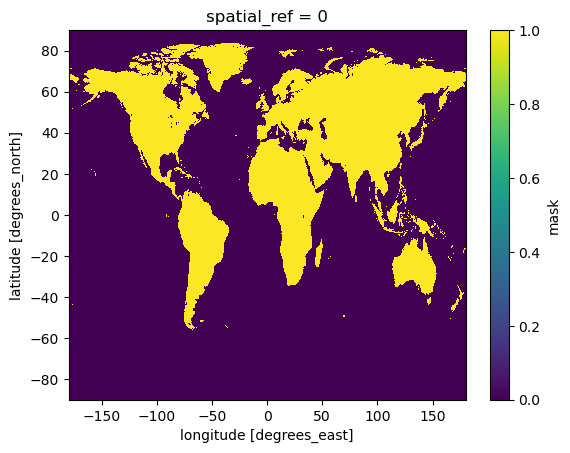

In [3]:
mask_daydev=xr.open_dataset(f_mask_daydev)
mask_daydev.mask.plot()

In [4]:
# save lat lon from mask
# we'll apply this to rst files so precision on the lat/lon values is the same
# avoids errors when trying to mask
lat=mask_daydev.lat
lon=mask_daydev.lon

### get radiation data for Jan 1980

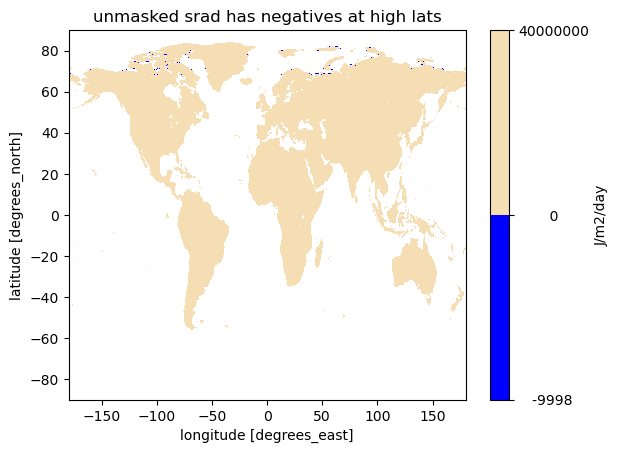

In [6]:
# get data
f=natsorted(glob.glob('/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/Climate/monthly/Srad_AgERA5_Hist_1980_01_5m.rst'))[0]

srad=xr.open_dataset(f,engine='rasterio').squeeze()['band_data']
del srad.coords['band']
srad=srad.rename({'x':'lon','y':'lat'})
srad=srad.rename('srad')
srad['lat']=lat
srad['lon']=lon
srad=srad.where(srad.lat>-60.)  # eliminate antarctica

# plot
srad.plot(colors=['blue','wheat'],levels=[-9998,0,4E7],cbar_kwargs={'label':'J/m2/day','format':'%8i'})
plt.title('unmasked srad has negatives at high lats')
plt.show()

In [7]:
# get info on the negative values
nneg=xr.where(srad.data<0,1,0).sum()
vals=np.unique(srad.where(srad<0))

print('data range after fill value -9999 has been converted to nan: ',srad.min().data,srad.max().data)
print('number of grids with negative values',nneg)
print( 'number of different negative values:', len(vals) )
vals

data range after fill value -9999 has been converted to nan:  -9908.016 36083732.0
number of grids with negative values 4073
number of different negative values: 4042


array([-9.9080156e+03, -9.8819746e+03, -9.8632939e+03, ...,
       -6.0952692e+00, -1.7454834e+00,            nan], dtype=float32)

###  apply gaez pxv daily dev mask (n data grids = 2,287,408) to see if it eliminates all negative values

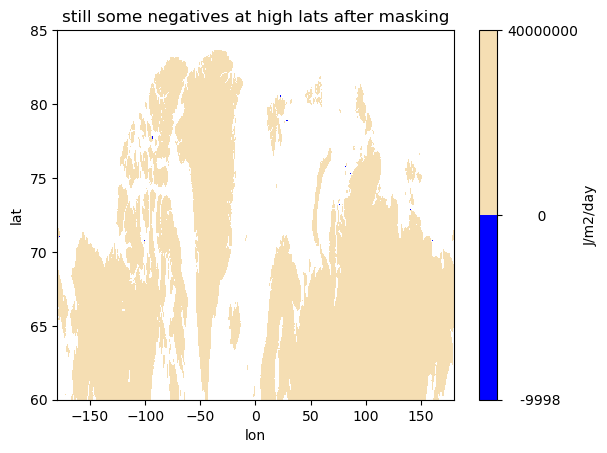

In [17]:
data_ddmasked=xr.where(mask_daydev>0,srad,np.nan)['mask']
data_ddmasked.name='srad'

data_ddmasked.sel(lat=slice(85,60)).plot(colors=['blue','wheat'],levels=[-9998,0,4E7],cbar_kwargs={'label':'J/m2/day','format':'%8i'})
plt.title('still some negatives at high lats after masking')
plt.show()

In [10]:
# get info on the negative values
nneg=xr.where(data_ddmasked.data<0,1,0).sum()
vals=np.unique(data_ddmasked.where(data_ddmasked<0))

print('data range after fill value -9999 has been converted to nan: ',data_ddmasked.min().data,data_ddmasked.max().data)
print('number of grids with negative values',nneg)
print( 'number of different negative values:', len(vals) )
vals

data range after fill value -9999 has been converted to nan:  -9863.294 36083732.0
number of grids with negative values 121
number of different negative values: 122


array([-9863.294  , -9613.712  , -9154.381  , -9152.226  , -9122.211  ,
       -9013.834  , -8887.252  , -8857.448  , -8506.232  , -8362.183  ,
       -8340.874  , -8119.588  , -7523.934  , -7490.644  , -7483.687  ,
       -7415.753  , -7390.3936 , -7381.2744 , -7340.6943 , -7304.7617 ,
       -7303.5825 , -7302.481  , -7296.2856 , -7240.6953 , -7218.3154 ,
       -7134.4053 , -6971.848  , -6962.96   , -6958.844  , -6942.437  ,
       -6884.9536 , -6790.7017 , -6694.8926 , -6675.174  , -6665.744  ,
       -6571.219  , -6559.8325 , -6531.16   , -6503.68   , -6499.527  ,
       -6460.089  , -6459.5615 , -6420.9263 , -6419.1006 , -6398.762  ,
       -6388.579  , -6336.652  , -6071.3022 , -5983.264  , -5966.2715 ,
       -5951.5605 , -5941.3467 , -5903.513  , -5855.1294 , -5835.241  ,
       -5808.287  , -5781.864  , -5773.3315 , -5760.826  , -5736.5825 ,
       -5675.9414 , -5654.0684 , -5634.524  , -5583.911  , -5454.155  ,
       -5268.238  , -5233.7515 , -5073.4507 , -5070.962  , -5029

###  apply a second mask from monthly wind rst file (n data grids = 2,268,708) to see if it eliminates all negative values


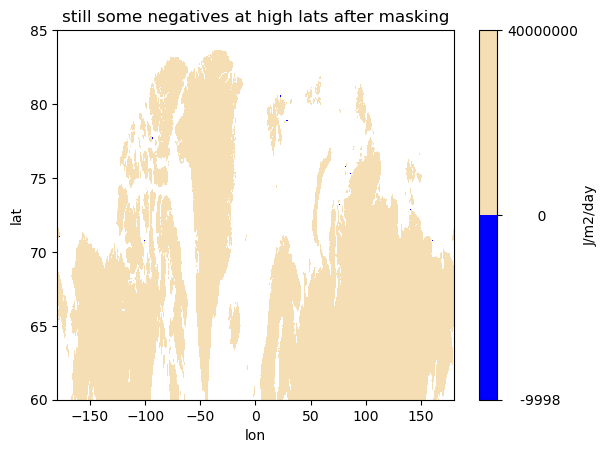

In [12]:
# get mask created from the monthly rst files, ngrids with data (no antarctica) = 2,268,708
mask_monthly=xr.open_dataset(f_mask_monthly)

# apply 2nd mask to srad data
data_monmasked=xr.where(mask_monthly>0,data_ddmasked,np.nan)['mask']
data_monmasked.name='srad'

# plot
data_monmasked.sel(lat=slice(85,60)).plot(colors=['blue','wheat'],levels=[-9998,0,4E7],cbar_kwargs={'label':'J/m2/day','format':'%8i'})
plt.title('still some negatives at high lats after masking')
plt.show()

In [13]:
# get info on the negative values
nneg=xr.where(data_monmasked.data<0,1,0).sum()
vals=np.unique(data_monmasked.where(data_monmasked<0))

print('data range after fill value -9999 has been converted to nan: ',data_monmasked.min().data,data_monmasked.max().data)
print('number of grids with negative values',nneg)
print( 'number of different negative values:', len(vals) )
vals

data range after fill value -9999 has been converted to nan:  -9613.712 36083732.0
number of grids with negative values 91
number of different negative values: 92


array([-9613.712  , -9152.226  , -9122.211  , -9013.834  , -8857.448  ,
       -8506.232  , -8362.183  , -8340.874  , -7523.934  , -7490.644  ,
       -7483.687  , -7415.753  , -7381.2744 , -7340.6943 , -7304.7617 ,
       -7303.5825 , -7302.481  , -7296.2856 , -7240.6953 , -7218.3154 ,
       -7134.4053 , -6971.848  , -6958.844  , -6942.437  , -6884.9536 ,
       -6790.7017 , -6675.174  , -6665.744  , -6571.219  , -6559.8325 ,
       -6531.16   , -6503.68   , -6499.527  , -6460.089  , -6459.5615 ,
       -6420.9263 , -6419.1006 , -6398.762  , -6388.579  , -6071.3022 ,
       -5983.264  , -5966.2715 , -5951.5605 , -5941.3467 , -5903.513  ,
       -5835.241  , -5781.864  , -5760.826  , -5736.5825 , -5675.9414 ,
       -5654.0684 , -5634.524  , -5583.911  , -5454.155  , -5268.238  ,
       -5233.7515 , -5073.4507 , -5070.962  , -4796.5215 , -4449.8125 ,
       -4409.5244 , -4285.9395 , -4279.1035 , -4102.5625 , -3968.9683 ,
       -3798.13   , -3748.0908 , -3739.6252 , -3697.1394 , -3530

### one more try, mask again with the ALOS admin mask, just in case it's different

In [14]:
# the rst ALOS mask, ngrids gt value 0 = 2,295,358
mask_ALOS=xr.open_dataset(f_mask_ALOS,engine='rasterio').squeeze()
# fix up metadata to avoid xarray fail
del mask_ALOS.coords['band']
mask_ALOS=mask_ALOS.rename({'x':'lon','y':'lat'})
mask_ALOS['lat']=lat # get lats with same precision as other masks
mask_ALOS['lon']=lon # get lats with same precision as other masks
mask_ALOS=mask_ALOS.where(mask_ALOS.lat>-60) # elim antarctica
mask_ALOS=xr.where(mask_ALOS>0,1,0)

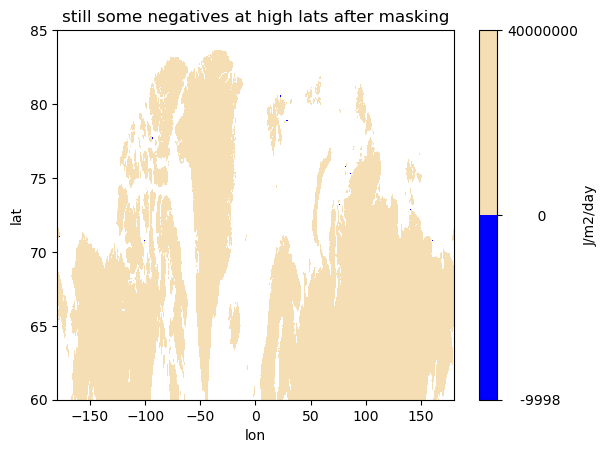

In [15]:
# apply a 3rd mask
data_alosmasked=xr.where(mask_monthly>0,data_monmasked,np.nan)['mask']
data_alosmasked.name='srad'

# plot
data_alosmasked.sel(lat=slice(85,60)).plot(colors=['blue','wheat'],levels=[-9998,0,4E7],cbar_kwargs={'label':'J/m2/day','format':'%8i'})
plt.title('still some negatives at high lats after masking')
plt.show()

In [16]:
# get info on the negative values
nneg=xr.where(data_alosmasked.data<0,1,0).sum()
vals=np.unique(data_alosmasked.where(data_alosmasked<0))

print('data range after fill value -9999 has been converted to nan: ',data_alosmasked.min().data,data_alosmasked.max().data)
print('number of grids with negative values',nneg)
print( 'number of different negative values:', len(vals) )
vals

data range after fill value -9999 has been converted to nan:  -9613.712 36083732.0
number of grids with negative values 91
number of different negative values: 92


array([-9613.712  , -9152.226  , -9122.211  , -9013.834  , -8857.448  ,
       -8506.232  , -8362.183  , -8340.874  , -7523.934  , -7490.644  ,
       -7483.687  , -7415.753  , -7381.2744 , -7340.6943 , -7304.7617 ,
       -7303.5825 , -7302.481  , -7296.2856 , -7240.6953 , -7218.3154 ,
       -7134.4053 , -6971.848  , -6958.844  , -6942.437  , -6884.9536 ,
       -6790.7017 , -6675.174  , -6665.744  , -6571.219  , -6559.8325 ,
       -6531.16   , -6503.68   , -6499.527  , -6460.089  , -6459.5615 ,
       -6420.9263 , -6419.1006 , -6398.762  , -6388.579  , -6071.3022 ,
       -5983.264  , -5966.2715 , -5951.5605 , -5941.3467 , -5903.513  ,
       -5835.241  , -5781.864  , -5760.826  , -5736.5825 , -5675.9414 ,
       -5654.0684 , -5634.524  , -5583.911  , -5454.155  , -5268.238  ,
       -5233.7515 , -5073.4507 , -5070.962  , -4796.5215 , -4449.8125 ,
       -4409.5244 , -4285.9395 , -4279.1035 , -4102.5625 , -3968.9683 ,
       -3798.13   , -3748.0908 , -3739.6252 , -3697.1394 , -3530

#### no change, this mask contains both of the others fully